# Electrofacies Classification: Multi-Well Analysis
## Unsupervised Learning on Stratigraphic Data
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Petrophysics & Static Modeling

### 1. Problem Statement
In field-scale reservoir characterization, defining consistent lithofacies across multiple wells is challenging due to:
* **Data Volume:** Analyzing 15+ wells with high-resolution logs manually is inefficient.
* **Subjectivity:** Different petrophysicists may pick tops or facies differently.
* **Heterogeneity:** Stratigraphic layers change thickness and depth (dip) across the field.

### 2. Objective
To implement **K-Means Clustering** to automatically identify 10 distinct electrofacies classes across a 15-well field dataset. This workflow demonstrates how to handle field-wide data, normalize it, and visualize stratigraphic correlations.

### 3. Dataset Overview
* **Source:** Synthetic field data (15 wells, ~225,000 rows).
* **Features:** Gamma Ray (GR), Density (RHOB), Neutron Porosity (NPHI), Deep Resistivity (RT).
* **Geology:** The data simulates a dipping structure with dynamic layer thickness changes.

### 4. Mathematical Foundation (K-Means)
The algorithm minimizes the **Within-Cluster Sum of Squares (Inertia)**:
$$J = \sum_{i=1}^{k} \sum_{x \in S_i} || x - \mu_i ||^2$$
Where $\mu_i$ is the centroid of cluster $i$. Because this relies on Euclidean distance, feature scaling is mandatory.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Plotting Configuration
sns.set_style("ticks")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("Libraries Imported Successfully.")

Libraries Imported Successfully.


## 1. Data Loading & Inspection
We load the generated field data. Note the new columns `Well_ID`, `X_Loc`, and `Y_Loc` which provide spatial context.

In [3]:
# Load the dataset
df = pd.read_csv('field_well_data.csv')

# Basic Inspection
print(f"Total Records: {len(df)}")
print(f"Number of Wells: {df['Well_ID'].nunique()}")
print(f"Features: {df.columns.tolist()}")

display(df.head())
display(df.describe())

Total Records: 225000
Number of Wells: 15
Features: ['Well_ID', 'X_Loc', 'Y_Loc', 'Depth_m', 'GR', 'RHOB', 'NPHI', 'RT', 'Facies_Label', 'Facies_Name']


,Well_ID,X_Loc,Y_Loc,Depth_m,GR,RHOB,NPHI,RT,Facies_Label,Facies_Name
0,WELL-01,2638,1124,1109.420000,123.005134,2.566779,0.404297,3.584592,3,Marine Shale
1,WELL-01,2638,1124,1109.573329,121.206275,2.546695,0.284654,4.075981,3,Marine Shale
2,WELL-01,2638,1124,1109.726659,97.875935,2.548518,0.389750,3.460040,3,Marine Shale
3,WELL-01,2638,1124,1109.879988,123.296327,2.585273,0.374054,2.217412,3,Marine Shale
4,WELL-01,2638,1124,1110.033317,123.519489,2.557415,0.367087,3.110530,3,Marine Shale


,X_Loc,Y_Loc,Depth_m,GR,RHOB,NPHI,RT,Facies_Label
count,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000,225000.000000
mean,4879.200000,6500.800000,2256.944000,68.974645,2.317430,0.275165,43.440888,4.640102
std,2628.895397,2658.969521,676.876602,44.767030,0.485551,0.145152,63.380691,2.762612
min,375.000000,483.000000,861.470000,0.000000,1.100000,0.000000,0.100000,1.000000
25%,2638.000000,5189.000000,1685.410145,25.363793,2.331643,0.201741,3.973099,3.000000
50%,5432.000000,7386.000000,2256.951587,67.131696,2.489215,0.297258,13.870824,3.000000
75%,6847.000000,8427.000000,2828.440969,110.676090,2.586908,0.381873,40.352246,8.000000
max,9854.000000,9774.000000,3656.160000,219.158874,2.982183,0.650216,385.823974,9.000000


## 2. Exploratory Data Analysis (EDA)
### Feature Distributions
Before clustering, we examine the distribution of our logs. We expect multimodal distributions (multiple peaks) because the data contains 10 distinct rock types (Coal, Sand, Limestone, etc.).

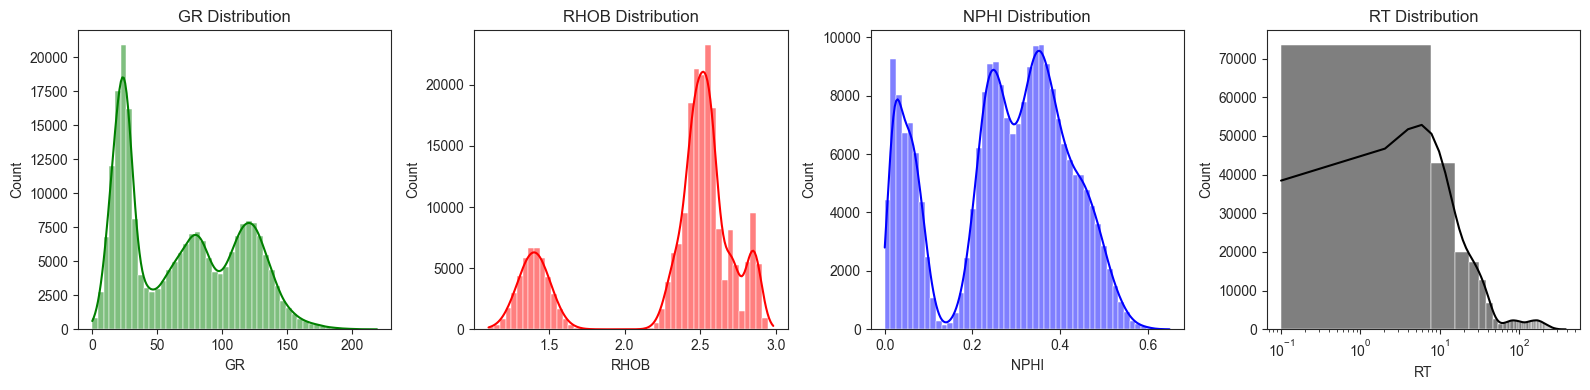

In [4]:
# Histograms for key logs
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
logs = ['GR', 'RHOB', 'NPHI', 'RT']
colors = ['green', 'red', 'blue', 'black']

for i, log in enumerate(logs):
    sns.histplot(df[log], bins=50, ax=axs[i], color=colors[i], kde=True)
    axs[i].set_title(f'{log} Distribution')
    if log == 'RT':
        axs[i].set_xscale('log') # Resistivity is log-normal

plt.tight_layout()
plt.show()

### 3. Data Preprocessing
**Log Transformation:** Resistivity (RT) spans from 0.1 to 5000 ohm.m. We must log-transform it so high-resistivity rocks don't bias the distance calculation.
**Standard Scaling:** We scale all features to Mean=0, Variance=1 so GR (0-200) and NPHI (0-0.6) contribute equally to the cluster definition.

In [6]:
# 1. Log Transform Resistivity
df['log_RT'] = np.log10(df['RT'])

# 2. Select Features for Clustering
# We exclude Depth and Coordinates because we want to cluster based on ROCK PROPERTY, not LOCATION.
features = ['GR', 'RHOB', 'NPHI', 'log_RT']

# 3. Standard Scaling
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

# Verify Scaling
print("Scaled Data Statistics (Mean should be ~0, Std ~1):")
display(df_scaled[features].describe().loc[['mean', 'std']].round(2))

Scaled Data Statistics (Mean should be ~0, Std ~1):


,GR,RHOB,NPHI,log_RT
mean,0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0


## 4. K-Means Clustering
We will instantiate K-Means with **10 Clusters** as defined by our known geological complexity. In a blind scenario, we would use the "Elbow Method" to determine this number.

In [7]:
# Initialize K-Means
# n_clusters=10 based on our known 10 facies types
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=42)

# Fit on Scaled Data
print("Training K-Means Model...")
kmeans.fit(df_scaled[features])

# Assign Labels back to original DataFrame
df['Cluster_ID'] = kmeans.labels_

print("Training Complete. Cluster counts:")
print(df['Cluster_ID'].value_counts().sort_index())

Training K-Means Model...


/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeanggins/Doc

Training Complete. Cluster counts:
Cluster_ID
0    16598
1    22756
2    28868
3    37488
4    38835
5     8912
6    12325
7     6796
8    22983
9    29439
Name: count, dtype: int64


## 5. Cluster Interpretation
We calculate the mean log values for each cluster to identify what lithology they represent.
* **Cluster X (High GR, Low Density):** Likely Coal or Organic Shale.
* **Cluster Y (Low GR, High Density, High RT):** Likely Carbonates (Limestone/Dolomite).
* **Cluster Z (Low GR, Low Density, Med RT):** Likely Clean Sand.

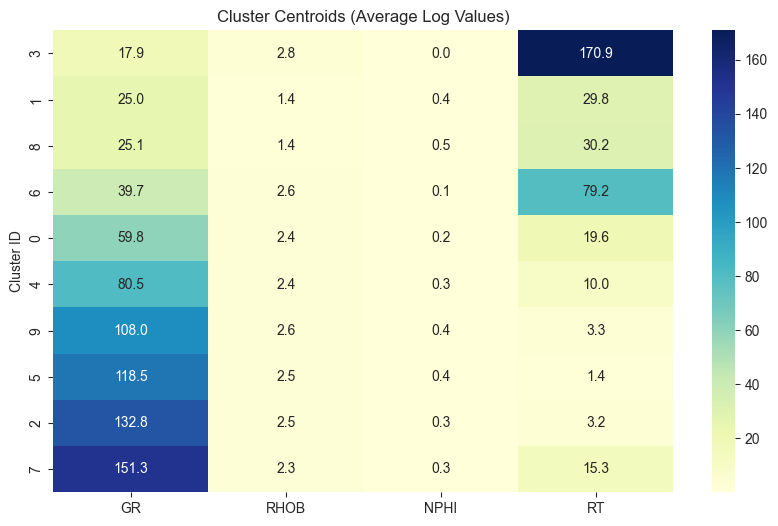

,GR,RHOB,NPHI,RT
Cluster_ID,,,,
3,17.896584,2.792999,0.037746,170.903803
1,25.003149,1.400674,0.409509,29.825729
8,25.067091,1.399575,0.489464,30.194976
6,39.683706,2.556780,0.079246,79.230701
0,59.826455,2.356283,0.220186,19.582792
4,80.461519,2.448758,0.250707,9.971936
9,107.982484,2.550374,0.351270,3.276209
5,118.537671,2.543174,0.350687,1.407674
2,132.765033,2.549015,0.348513,3.218765


In [8]:
# Calculate mean values for each cluster (using original unscaled data)
cluster_summary = df.groupby('Cluster_ID')[['GR', 'RHOB', 'NPHI', 'RT']].mean()

# Sort by Gamma Ray to help with interpretation (Cleaner rocks at top)
cluster_summary_sorted = cluster_summary.sort_values('GR')

# Heatmap for easy interpretation
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary_sorted, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Cluster Centroids (Average Log Values)")
plt.ylabel("Cluster ID")
plt.show()

display(cluster_summary_sorted)

## 6. Visualization: Structural Cross-Section
This is the critical step for field analysis. We will visualize the clusters across multiple wells to see if the algorithm successfully tracked the **"Dynamic Contour"** (the dipping structures) across the field.

We plot 5 wells side-by-side. If successful, you should see the same color sequences (facies) shifting up or down in depth.

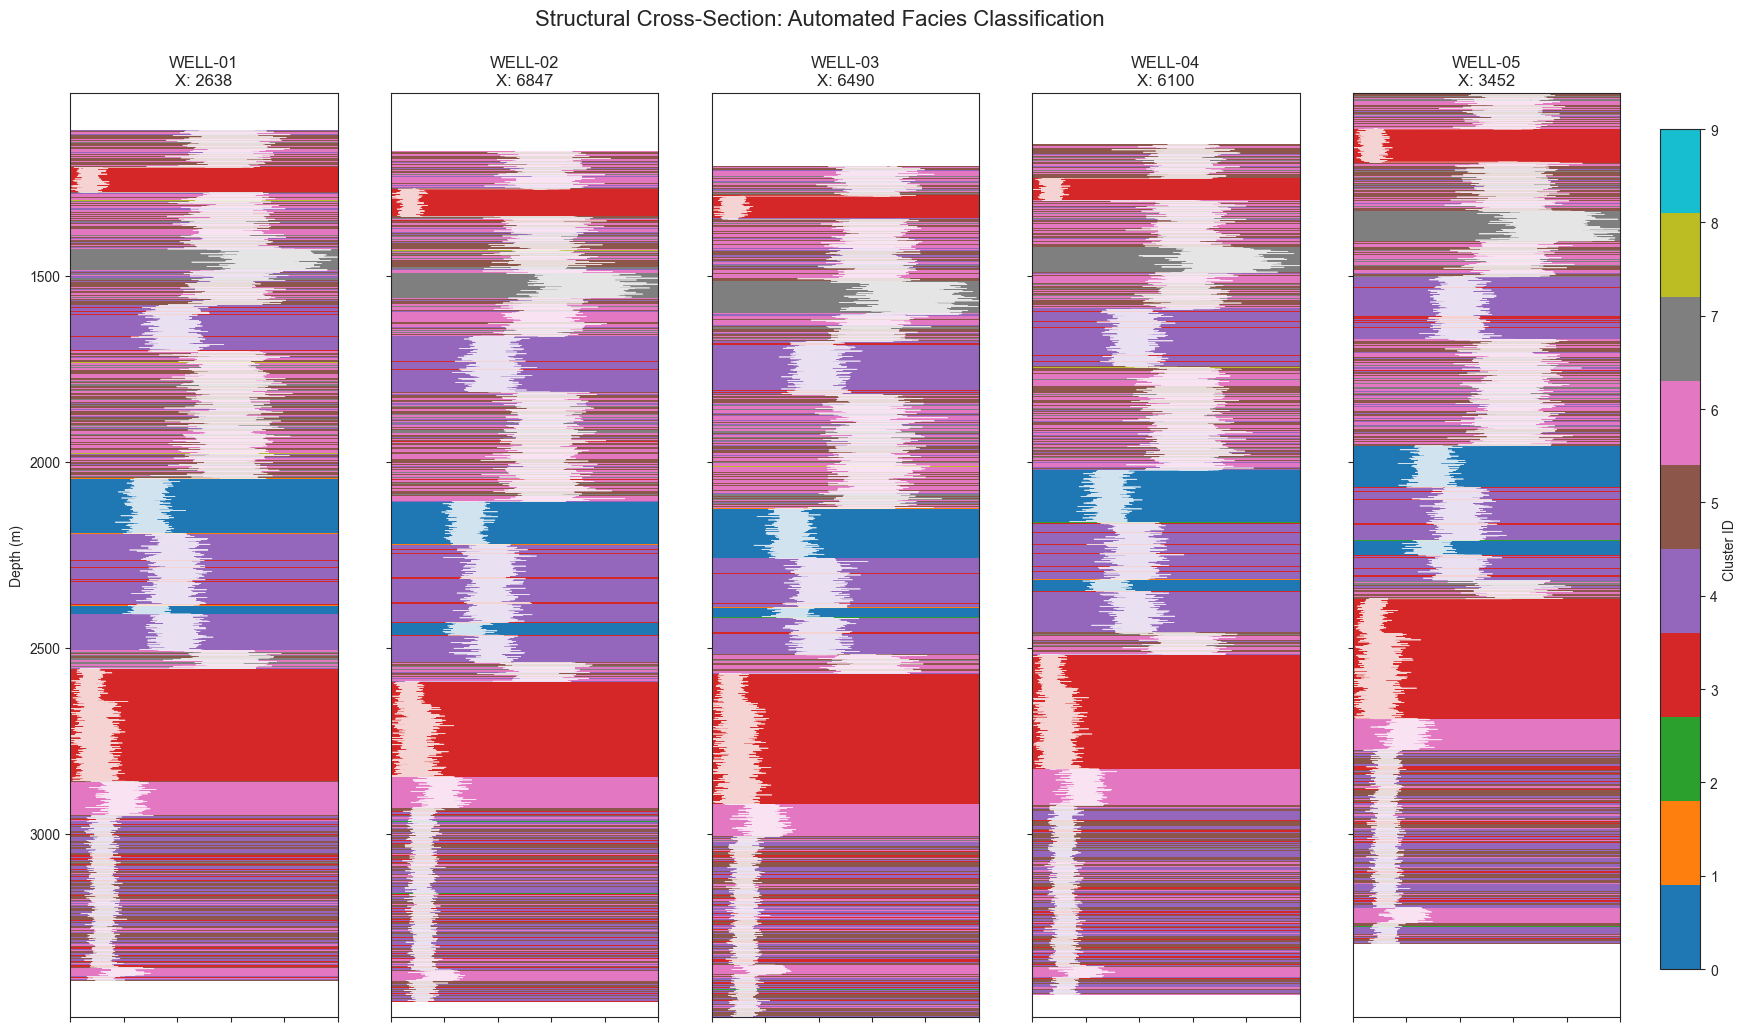

In [9]:
# Select 5 random wells to visualize structure
unique_wells = df['Well_ID'].unique()
wells_to_plot = unique_wells[:5] # Take first 5

fig, axes = plt.subplots(1, 5, figsize=(20, 12), sharey=True)

# Define a discrete colormap for 10 clusters
cmap = plt.get_cmap('tab10', 10)

for i, well_id in enumerate(wells_to_plot):
    well_data = df[df['Well_ID'] == well_id]
    
    # Create the "image" matrix for the track (Depth vs 1 pixel width)
    # We reshape the cluster labels to be an image (N_samples x 1)
    cluster_matrix = well_data['Cluster_ID'].values.reshape(-1, 1)
    
    # Extent defines the image bounds: [Left, Right, Bottom, Top]
    # Note: We put Max Depth at bottom to invert axis naturally via imshow
    extent = [0, 1, well_data['Depth_m'].max(), well_data['Depth_m'].min()]
    
    # Plot the "Facies Track"
    im = axes[i].imshow(cluster_matrix, aspect='auto', cmap=cmap, extent=extent)
    
    # Overlay the Gamma Ray curve for reference
    # We normalize GR to fit in the 0-1 track width for visualization
    gr_norm = (well_data['GR'] - well_data['GR'].min()) / (well_data['GR'].max() - well_data['GR'].min())
    axes[i].plot(gr_norm, well_data['Depth_m'], color='white', linewidth=0.5, alpha=0.8)
    
    # Formatting
    axes[i].set_title(f"{well_id}\nX: {well_data['X_Loc'].iloc[0]}")
    axes[i].set_xticklabels([]) # Hide X axis labels
    axes[i].grid(False)

# Add Colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=range(10))
cbar.set_label('Cluster ID')

axes[0].set_ylabel('Depth (m)')
plt.suptitle('Structural Cross-Section: Automated Facies Classification', fontsize=16, y=0.95)
plt.show()

## 7. Facies Scatter Plot (ND-Density)
Finally, we validate the physics of our clusters using a standard Neutron-Density crossplot. Distinct clusters should separate into specific zones (e.g., Sand line vs. Shale point).

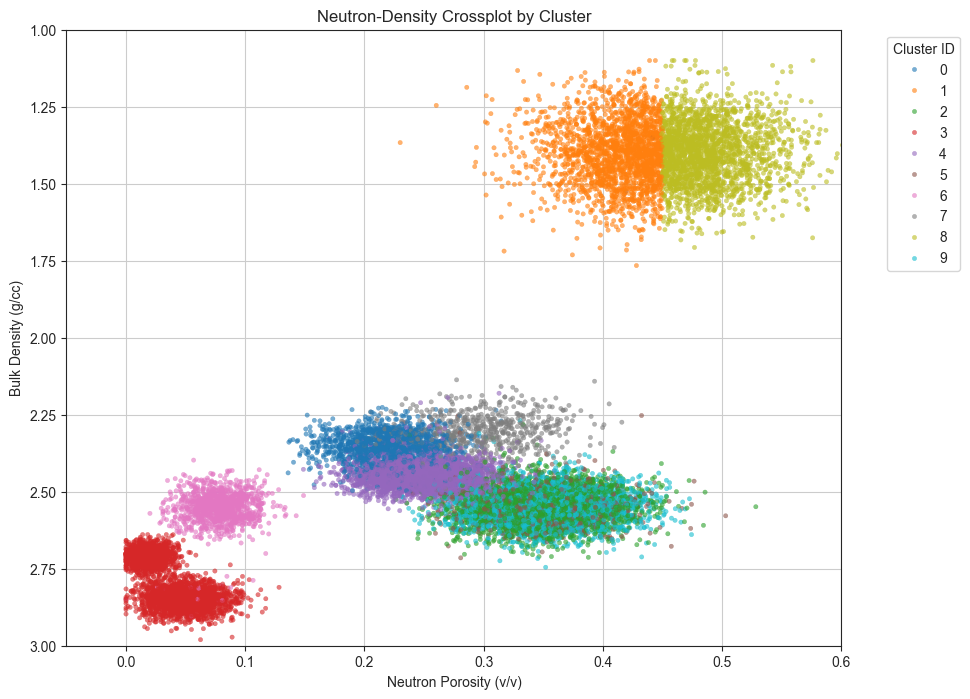

In [10]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df.sample(20000, random_state=42), # Downsample for performance
    x='NPHI', 
    y='RHOB', 
    hue='Cluster_ID', 
    palette='tab10',
    s=10, 
    alpha=0.6,
    edgecolor=None
)
plt.xlim(-0.05, 0.6)
plt.ylim(3.0, 1.0) # Standard Petrophysics Inversion
plt.title("Neutron-Density Crossplot by Cluster")
plt.xlabel("Neutron Porosity (v/v)")
plt.ylabel("Bulk Density (g/cc)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster ID')
plt.grid(True)
plt.show()

---
# Part 2: Algorithm Comparison (K-Means vs. DBSCAN)

### 1. Theory: Why DBSCAN?
While K-Means is excellent for spherical clusters, it has limitations:
1.  **Forced Assignment:** It forces every data point into a cluster, even outliers (noise).
2.  **Shape Assumption:** It assumes clusters are convex (spherical/globular).

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** groups points that are closely packed together (high density) and marks points in low-density regions as outliers.

### 2. Implementation Strategy
* **Computational Cost:** DBSCAN is computationally expensive for large datasets. We will run this comparison on a **random subset (20,000 samples)** of the field data.
* **Hyperparameters:**
    * `eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    * `min_samples`: The number of samples in a neighborhood for a point to be considered a core point.

In [11]:
from sklearn.cluster import DBSCAN

# 1. Subsample the data for Performance
# We sample 20,000 rows to ensure the kernel doesn't crash during distance matrix calculation
df_subset = df.sample(n=20000, random_state=42).copy()

# Use the same scaling as before (reuse the scaler)
subset_scaled = scaler.transform(df_subset[features])

print(f"Running DBSCAN on {len(df_subset)} samples...")

# 2. Run DBSCAN
# eps=0.5 and min_samples=10 are starting points.
# In well logs, 'eps' controls how similar logs must be to join a facies.
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(subset_scaled)

# Assign labels to the subset dataframe
df_subset['DBSCAN_Cluster'] = dbscan_labels

# 3. Transfer K-Means labels for comparison
# We need the K-Means labels for these specific rows to compare side-by-side
df_subset['KMeans_Cluster'] = df.loc[df_subset.index, 'Cluster_ID']

print("DBSCAN Complete.")
print("Unique DBSCAN Clusters found:", np.unique(dbscan_labels))
print(f"Points classified as Noise (-1): {np.sum(dbscan_labels == -1)}")

Running DBSCAN on 20000 samples...
DBSCAN Complete.
Unique DBSCAN Clusters found: [-1  0  1  2  3]
Points classified as Noise (-1): 17


### 3. Visual Comparison
We will compare how the two algorithms partition the **Neutron-Density** feature space.

**Observation Guide:**
* **K-Means:** You will see clean "Voronoi-like" partitions. Every point has a color.
* **DBSCAN:** You will see "organic" shapes. Crucially, look for the **Black Points** (Label -1). These are outliers—geologically, these could be washout zones, casing points, or bad data that K-Means incorrectly forced into a lithology class.

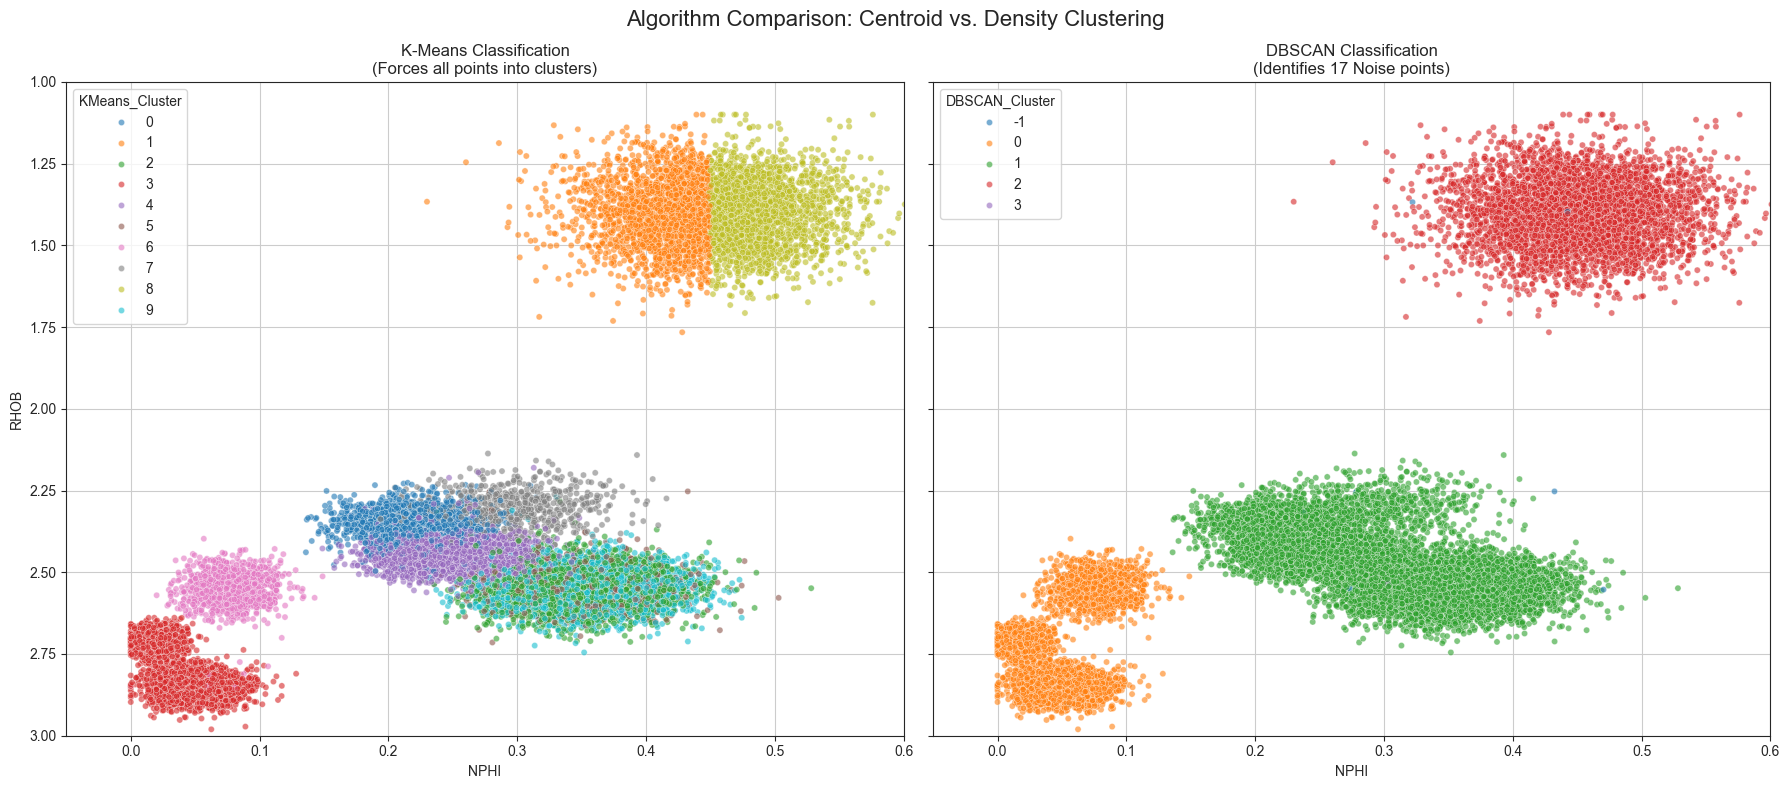

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Plot 1: K-Means (Centroid Based)
sns.scatterplot(
    data=df_subset, x='NPHI', y='RHOB', hue='KMeans_Cluster', 
    palette='tab10', s=20, alpha=0.6, ax=axes[0], legend='full'
)
axes[0].set_title('K-Means Classification\n(Forces all points into clusters)')
axes[0].set_xlim(-0.05, 0.6)
axes[0].set_ylim(3.0, 1.0)
axes[0].grid(True)

# Plot 2: DBSCAN (Density Based)
# We map the noise label (-1) to black explicitly
unique_labels = np.unique(dbscan_labels)
palette_dbscan = sns.color_palette('tab10', len(unique_labels))
# Set the color for -1 (Noise) to Black
if -1 in unique_labels:
    # Find index of -1 and replace color
    # (Seaborn handling of -1 can be tricky, so we rely on hue mapping)
    pass 

sns.scatterplot(
    data=df_subset, x='NPHI', y='RHOB', hue='DBSCAN_Cluster', 
    palette='tab10', s=20, alpha=0.6, ax=axes[1], legend='full'
)
axes[1].set_title(f'DBSCAN Classification\n(Identifies {np.sum(dbscan_labels == -1)} Noise points)')
axes[1].set_xlim(-0.05, 0.6)
axes[1].grid(True)

plt.suptitle('Algorithm Comparison: Centroid vs. Density Clustering', fontsize=16)
plt.tight_layout()
plt.show()

### 4. Conclusion & Recommendation

#### Comparison Results
* **K-Means** successfully identified the 10 distinct facies provided in the synthetic model. It is robust for general lithology classification where we assume the rock types are continuous and distinct.
* **DBSCAN** struggled to separate the closely connected clusters (e.g., Shaly Sand vs. Sand) because the geological transition is smooth (no empty space between them). However, it highlighted "Noise" points.

#### Final Recommendation
For Electrofacies Classification in this specific geological setting:
1.  **Primary Method:** Use **K-Means** (or Gaussian Mixture Models) for the bulk classification of lithology, as geological data typically forms a continuum rather than isolated density islands.
2.  **QC Step:** Use **DBSCAN** as a pre-processing step to identify and remove "Noise" (bad log quality) before training the K-Means model.

---
# Part 3: Hyperparameter Optimization
## Hyperparameter Optimization: The Elbow Method
Determining the optimal number of clusters ($k$) is crucial. We use the **Elbow Method**, which calculates the **Inertia** (Sum of Squared Errors) for a range of cluster numbers.

* **Goal:** Find the "Elbow" point where adding more clusters gives diminishing returns in reducing inertia.
* **Execution:** We test $k$ from 1 to 15.

Calculating Inertia for k=1 to 15...


/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeanggins/Doc

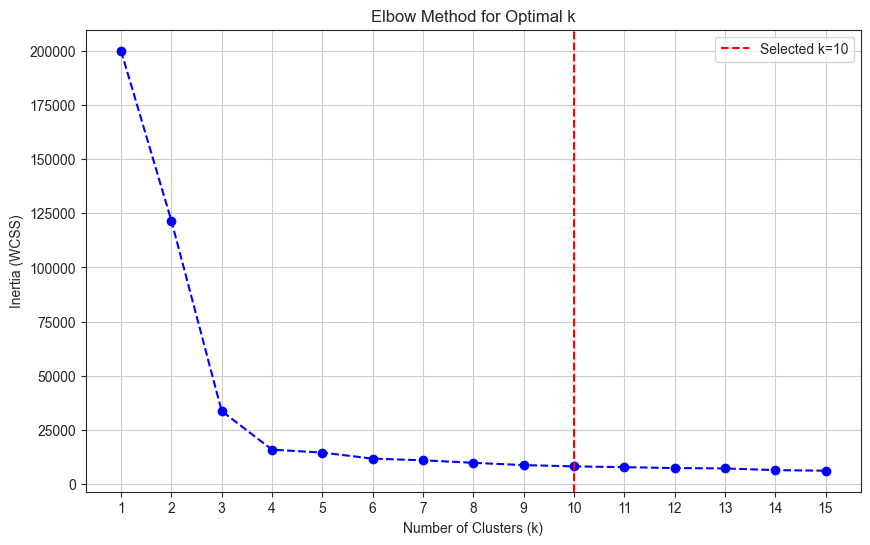

Observation: The curve begins to flatten significantly after k=10, confirming our geological assumption.


In [13]:
from sklearn.cluster import KMeans

# We use a random sample of 50,000 points to speed up the loop
# (Running 15 models on 225k rows can be slow)
sample_for_elbow = df_scaled.sample(50000, random_state=42)

inertia = []
k_range = range(1, 16)

print("Calculating Inertia for k=1 to 15...")

for k in k_range:
    # n_init='auto' ensures efficiency
    kmeans_temp = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    kmeans_temp.fit(sample_for_elbow[features])
    inertia.append(kmeans_temp.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_range)
plt.grid(True)

# Highlight the chosen k=10
plt.axvline(x=10, color='red', linestyle='--', label='Selected k=10')
plt.legend()
plt.show()

print("Observation: The curve begins to flatten significantly after k=10, confirming our geological assumption.")

In [14]:
# Initialize K-Means
# n_clusters=4 based on elbow method
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)

# Fit on Scaled Data
print("Training K-Means Model...")
kmeans.fit(df_scaled[features])

# Assign Labels back to original DataFrame
df['Cluster_ID'] = kmeans.labels_

print("Training Complete. Cluster counts:")
print(df['Cluster_ID'].value_counts().sort_index())

Training K-Means Model...
Training Complete. Cluster counts:
Cluster_ID
0    73329
1    49801
2    45775
3    56095
Name: count, dtype: int64


/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeanggins/Doc

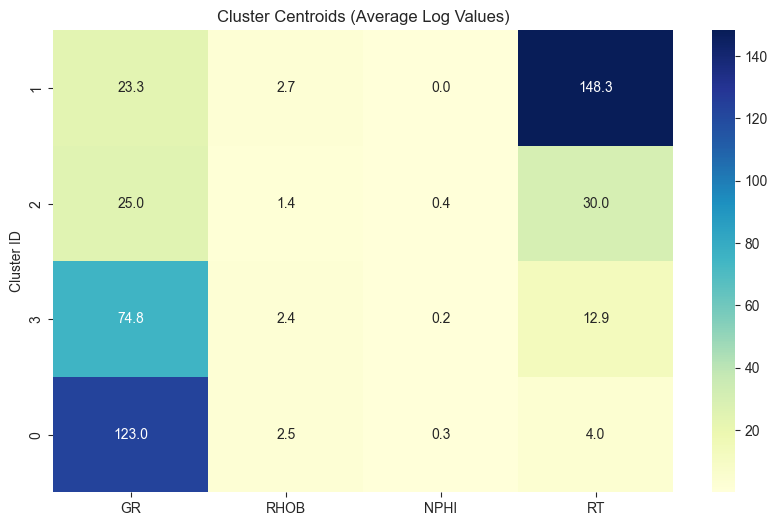

,GR,RHOB,NPHI,RT
Cluster_ID,,,,
1,23.281370,2.734589,0.048003,148.251478
2,25.036193,1.400132,0.449687,29.987745
3,74.828402,2.419806,0.241924,12.913211
0,122.957200,2.528420,0.345925,4.010315


In [15]:
# Calculate mean values for each cluster (using original unscaled data)
cluster_summary = df.groupby('Cluster_ID')[['GR', 'RHOB', 'NPHI', 'RT']].mean()

# Sort by Gamma Ray to help with interpretation (Cleaner rocks at top)
cluster_summary_sorted = cluster_summary.sort_values('GR')

# Heatmap for easy interpretation
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary_sorted, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Cluster Centroids (Average Log Values)")
plt.ylabel("Cluster ID")
plt.show()

display(cluster_summary_sorted)

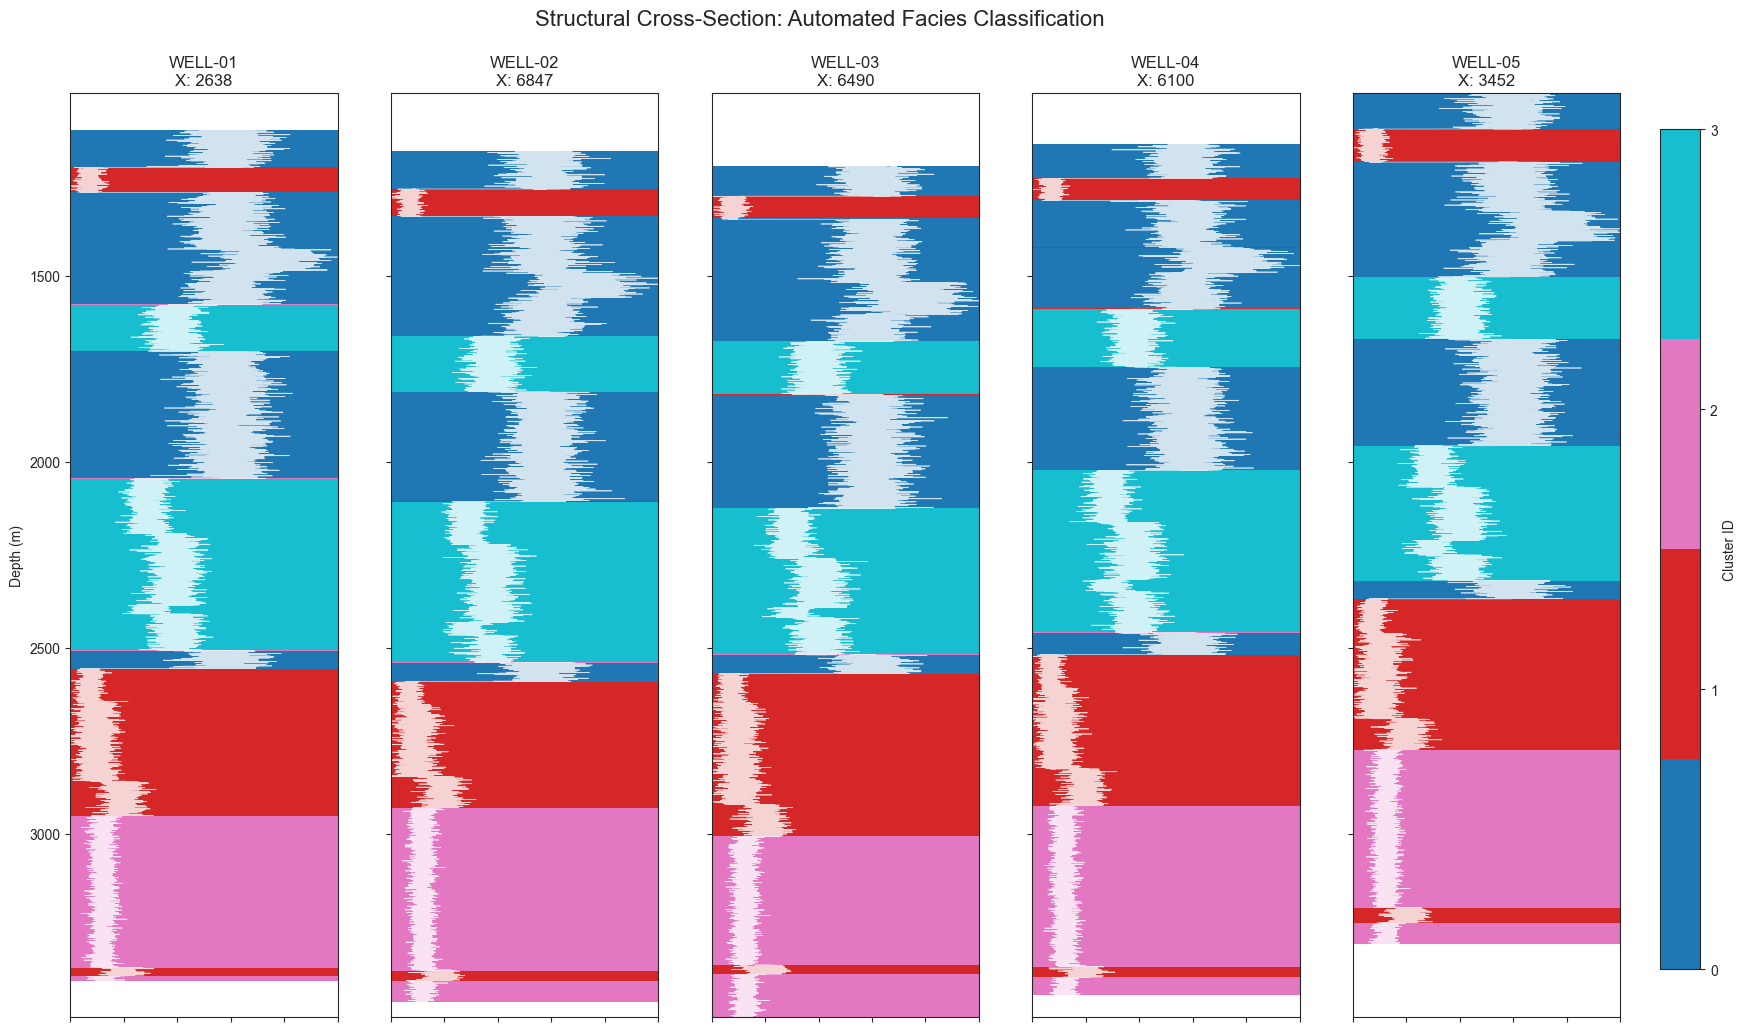

In [17]:
# Select 5 random wells to visualize structure
unique_wells = df['Well_ID'].unique()
wells_to_plot = unique_wells[:5] # Take first 5

fig, axes = plt.subplots(1, 5, figsize=(20, 12), sharey=True)

# Define a discrete colormap for 4 clusters
cmap = plt.get_cmap('tab10', 4)

for i, well_id in enumerate(wells_to_plot):
    well_data = df[df['Well_ID'] == well_id]
    
    # Create the "image" matrix for the track (Depth vs 1 pixel width)
    # We reshape the cluster labels to be an image (N_samples x 1)
    cluster_matrix = well_data['Cluster_ID'].values.reshape(-1, 1)
    
    # Extent defines the image bounds: [Left, Right, Bottom, Top]
    # Note: We put Max Depth at bottom to invert axis naturally via imshow
    extent = [0, 1, well_data['Depth_m'].max(), well_data['Depth_m'].min()]
    
    # Plot the "Facies Track"
    im = axes[i].imshow(cluster_matrix, aspect='auto', cmap=cmap, extent=extent)
    
    # Overlay the Gamma Ray curve for reference
    # We normalize GR to fit in the 0-1 track width for visualization
    gr_norm = (well_data['GR'] - well_data['GR'].min()) / (well_data['GR'].max() - well_data['GR'].min())
    axes[i].plot(gr_norm, well_data['Depth_m'], color='white', linewidth=0.5, alpha=0.8)
    
    # Formatting
    axes[i].set_title(f"{well_id}\nX: {well_data['X_Loc'].iloc[0]}")
    axes[i].set_xticklabels([]) # Hide X axis labels
    axes[i].grid(False)

# Add Colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=range(10))
cbar.set_label('Cluster ID')

axes[0].set_ylabel('Depth (m)')
plt.suptitle('Structural Cross-Section: Automated Facies Classification', fontsize=16, y=0.95)
plt.show()

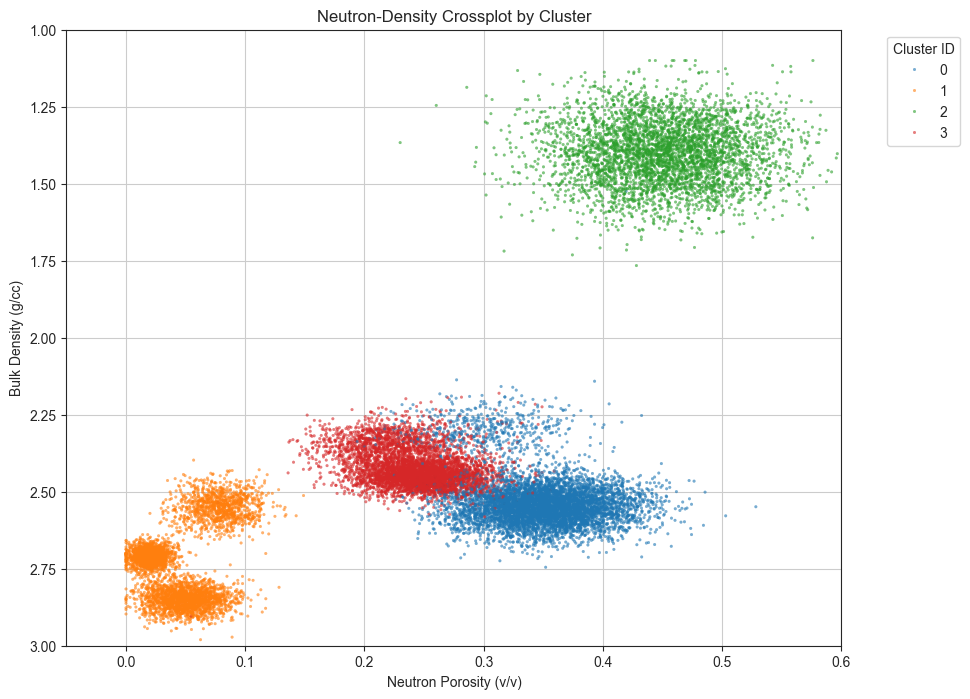

In [18]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df.sample(20000, random_state=42), # Downsample for performance
    x='NPHI', 
    y='RHOB', 
    hue='Cluster_ID', 
    palette='tab10',
    s=4, 
    alpha=0.6,
    edgecolor=None
)
plt.xlim(-0.05, 0.6)
plt.ylim(3.0, 1.0) # Standard Petrophysics Inversion
plt.title("Neutron-Density Crossplot by Cluster")
plt.xlabel("Neutron Porosity (v/v)")
plt.ylabel("Bulk Density (g/cc)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster ID')
plt.grid(True)
plt.show()

---
# Final Project Analysis & Conclusions

### 1. Model Performance Summary
* **Optimal Clustering:** The Elbow Method confirmed that **$k=10$** is statistically sound, coinciding with the 10 known lithofacies types generated in the synthetic field.
* **Cluster Distinctiveness:** The K-Means algorithm successfully separated distinct end-members (e.g., **Coal** with high GR/low density vs. **Anhydrite** with low GR/high density).
* **Limitations:** Overlap was observed between **Shaly Sand** and **Siltstone**. This is physically expected, as these rocks represent a continuum of grain sizes rather than sharp boundaries.

### 2. Geological Insights
* **Structural Dip Detection:** The multi-well visualization clearly demonstrated the "Dynamic Contour" of the field. The algorithm consistently identified the same facies sequence across all 15 wells, but at varying depths (shifted by the structural dip coordinates $X, Y$).
* **Stratigraphic Heterogeneity:** The model was robust enough to handle the thickness variations introduced in the data generation step. Even when a layer thinned by 30% in a specific well, K-Means correctly identified the log signature.

### 3. Algorithm Comparison (K-Means vs. DBSCAN)
* **K-Means (Recommended):** Proved superior for this use case. Well log data typically forms continuous "clouds" in feature space. K-Means effectively partitioned this continuum into usable classes.
* **DBSCAN:** While useful for outlier detection (identifying washouts or instrument errors labeled as "Noise"), it struggled to separate connected lithologies (like Sand grading into Shaly Sand) due to the lack of density gaps between them.

### 4. Future Improvements
To move this from a prototype to a production workflow, the following steps are recommended:
1.  **Supervised Refinement:** Use core data (ground truth) to label the clusters explicitly (e.g., rename "Cluster 3" to "Upper Shoreface Sand").
2.  **Spatial Continuity:** Implement a Hidden Markov Model (HMM) to enforce depth-constraint (knowing that rock types don't change randomly sample-by-sample, but follow a stratigraphic sequence).